# AD Targeting User Clusters
Project members: Jesus Casas

In [ ]:
# Importing Packages
install.packages("googledrive")
install.packages("factoextra")
install.packages("gtools")
install.packages("patchwork")
install.packages("rlang")
library(googledrive)
library(ggplot2)
library(cluster)
library(factoextra)
library(gtools)
library(readr)
library(dplyr)
library(class)
library(gridExtra)
library(patchwork)
library(rlang)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘lazyeval’, ‘carData’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘crosstalk’, ‘estimability’, ‘numDeriv’, ‘mvtnorm’, ‘corrplot’, ‘viridis’, ‘car’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘plyr’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’, ‘ggrepel’

Warning message in install.packages("factoextra"):
“installation of package ‘leaps’ had non-zero exit status”
“installation of package ‘FactoMineR’ had non-zero exit status”
“installation of package ‘factoextra’ had non-zero exit status”
“installation of package ‘patchwork’ had non-zero exit status”



# Step 1: Load in dataset

In [ ]:
df <- read.csv("synthetic_social_media_users.csv", header = TRUE)
my_data <- subset(df, select = -c(id, post_text))
print(colnames(my_data))
head(my_data)

 [1] "age"                   "friends"               "days_active"          
 [4] "hours_active"          "likes"                 "posts"                
 [7] "cluster_name"          "sex"                   "name"                 
[10] "date_of_birth"         "city"                  "state"                
[13] "relationship_status"   "education"             "groups_joined"        
[16] "pages_liked"           "primary_device"        "last_active_hours_ago"
[19] "events_responded"      "notification_setting"  "privacy_setting"      
[22] "account_age_years"     "photos_uploaded"       "comments_30days"      


,age,friends,days_active,hours_active,likes,posts,cluster_name,sex,name,date_of_birth,⋯,groups_joined,pages_liked,primary_device,last_active_hours_ago,events_responded,notification_setting,privacy_setting,account_age_years,photos_uploaded,comments_30days
,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>,<int>
1,30.14570,420,27,63,1180,34,Young Active,M,Michael Harris,1994-02-11,⋯,11,238,Mobile (iOS),0.1,8,All notifications,Only me,7.6,225,77
2,29.57387,443,25,47,1079,41,Young Active,F,Debra Torres,1994-10-12,⋯,12,92,Mobile (iOS),0.6,11,Minimal notifications,Friends only,8.1,495,29
3,24.98772,401,25,59,1198,29,Young Active,F,Mary Wilson,2000-01-23,⋯,14,152,Mobile (iOS),3.2,8,Important notifications only,Friends only,9.8,486,98
4,25.68005,492,27,59,1125,27,Young Active,M,Justin Miller,1998-11-20,⋯,18,154,Mobile (iOS),2.3,6,Minimal notifications,Friends only,8.0,450,85
5,36.39923,160,17,19,619,17,Middle-aged Moderate,M,Daniel Davis,1988-08-26,⋯,8,175,Desktop (Windows),3.4,3,Minimal notifications,Friends of friends,14.6,504,43
6,29.00938,317,20,31,951,19,Young Adult Active,F,Helen Scott,1995-09-16,⋯,14,146,Desktop (Mac),5.2,4,All notifications,Public,11.4,604,75


In [ ]:
# Checking for any missing values
colnames(my_data)[colSums(is.na(my_data)) > 0]

character(0)

## Step 2: Exploring the dataset
- Column data types
- Summary of dataset feature distributions
- Identifying categorical numerical or text columns

In [ ]:
# Inspect the structure of the dataset to see column types
str(my_data)

# Get a summary of the dataset to see distributions and potential missing values
summary(my_data)

# Identify numeric columns (T/F for each column)
num_cols <- sapply(my_data, is.numeric)
print("Numeric columns:")
print(names(my_data)[num_cols])

# Identify categorical/text columns (character or factor)
cat_cols <- sapply(my_data, function(x) is.character(x) || is.factor(x))
print("Categorical/Text columns:")
print(names(my_data)[cat_cols])


'data.frame':	1000 obs. of  24 variables:
 $ age                  : num  30.1 29.6 25 25.7 36.4 ...
 $ friends              : int  420 443 401 492 160 317 244 141 501 195 ...
 $ days_active          : int  27 25 25 27 17 20 17 18 28 25 ...
 $ hours_active         : int  63 47 59 59 19 31 26 27 56 44 ...
 $ likes                : int  1180 1079 1198 1125 619 951 383 371 1151 794 ...
 $ posts                : int  34 41 29 27 17 19 15 4 33 31 ...
 $ cluster_name         : chr  "Young Active" "Young Active" "Young Active" "Young Active" ...
 $ sex                  : chr  "M" "F" "F" "M" ...
 $ name                 : chr  "Michael Harris" "Debra Torres" "Mary Wilson" "Justin Miller" ...
 $ date_of_birth        : chr  "1994-02-11" "1994-10-12" "2000-01-23" "1998-11-20" ...
 $ city                 : chr  "Portland" "San Jose" "Portland" "Dallas" ...
 $ state                : chr  "OR" "CA" "OR" "TX" ...
 $ relationship_status  : chr  "In a relationship" "In a relationship" "In a relationship

      age           friends       days_active     hours_active  
 Min.   :12.73   Min.   :  0.0   Min.   : 0.00   Min.   : 0.00  
 1st Qu.:27.45   1st Qu.:139.5   1st Qu.:11.00   1st Qu.:12.00  
 Median :34.78   Median :253.5   Median :17.00   Median :29.00  
 Mean   :38.59   Mean   :259.0   Mean   :16.82   Mean   :31.41  
 3rd Qu.:48.10   3rd Qu.:379.2   3rd Qu.:22.00   3rd Qu.:50.00  
 Max.   :76.15   Max.   :569.0   Max.   :30.00   Max.   :87.00  
     likes            posts       cluster_name           sex           
 Min.   :   0.0   Min.   : 0.00   Length:1000        Length:1000       
 1st Qu.: 329.2   1st Qu.: 8.00   Class :character   Class :character  
 Median : 623.5   Median :16.00   Mode  :character   Mode  :character  
 Mean   : 663.5   Mean   :16.78                                        
 3rd Qu.:1033.2   3rd Qu.:25.00                                        
 Max.   :1464.0   Max.   :42.00                                        
     name           date_of_birth        

[1] "Numeric columns:"
 [1] "age"                   "friends"               "days_active"          
 [4] "hours_active"          "likes"                 "posts"                
 [7] "groups_joined"         "pages_liked"           "last_active_hours_ago"
[10] "events_responded"      "account_age_years"     "photos_uploaded"      
[13] "comments_30days"      
[1] "Categorical/Text columns:"
 [1] "cluster_name"         "sex"                  "name"                
 [4] "date_of_birth"        "city"                 "state"               
 [7] "relationship_status"  "education"            "primary_device"      
[10] "notification_setting" "privacy_setting"     


# Step 3: Data preprocessing
- Hot one encoding for categorical features

In [ ]:
library(dplyr)

# Remove "name" and "date_of_birth" from the original dataset
my_data <- my_data %>%
  select(-name, -date_of_birth, -cluster_name)

# Define the exact columns to one-hot encode
encode_cols <- c("sex", "relationship_status", "education",
                 "primary_device", "notification_setting", "privacy_setting", "state", "city" )

# Convert to factors
my_data[encode_cols] <- lapply(my_data[encode_cols], as.factor)

# Create a copy of the dataset with one-hot encoded columns
encoded_data <- my_data %>%
  select(-all_of(encode_cols)) %>%
  bind_cols(as.data.frame(model.matrix(~ . - 1, my_data[encode_cols])))

# Print all column names
print(colnames(encoded_data))
head(encoded_data)

 [1] "age"                                             
 [2] "friends"                                         
 [3] "days_active"                                     
 [4] "hours_active"                                    
 [5] "likes"                                           
 [6] "posts"                                           
 [7] "groups_joined"                                   
 [8] "pages_liked"                                     
 [9] "last_active_hours_ago"                           
[10] "events_responded"                                
[11] "account_age_years"                               
[12] "photos_uploaded"                                 
[13] "comments_30days"                                 
[14] "sexF"                                            
[15] "sexM"                                            
[16] "relationship_statusEngaged"                      
[17] "relationship_statusIn a relationship"            
[18] "relationship_statusIn an open relationship

,age,friends,days_active,hours_active,likes,posts,groups_joined,pages_liked,last_active_hours_ago,events_responded,⋯,cityNashville,cityNew York,cityPhiladelphia,cityPhoenix,cityPortland,citySan Antonio,citySan Diego,citySan Francisco,citySan Jose,citySeattle
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30.14570,420,27,63,1180,34,11,238,0.1,8,⋯,0,0,0,0,1,0,0,0,0,0
2,29.57387,443,25,47,1079,41,12,92,0.6,11,⋯,0,0,0,0,0,0,0,0,1,0
3,24.98772,401,25,59,1198,29,14,152,3.2,8,⋯,0,0,0,0,1,0,0,0,0,0
4,25.68005,492,27,59,1125,27,18,154,2.3,6,⋯,0,0,0,0,0,0,0,0,0,0
5,36.39923,160,17,19,619,17,8,175,3.4,3,⋯,0,0,0,0,0,0,0,0,0,0
6,29.00938,317,20,31,951,19,14,146,5.2,4,⋯,0,0,0,0,0,0,0,0,0,0


# Step 4: Scale data set
- Function scale Standerdized the dataset
- Each column mean becomes 0
- Each column standard deviation becomes 1

In [ ]:
# Scale the data for better clustering
data_scaled <- scale(my_data[ , sapply(my_data, is.numeric)])

# Step 5: Performing K-Means cluster on dataset
- 4 different groups for 4 different advertisements

In [ ]:
set.seed(123)  # For reproducibility
k <- 4        # Number of clusters
kmeans_result <- kmeans(data_scaled, centers = k, nstart = 25)

# Add cluster labels to the original data frame
my_data$cluster <- as.factor(kmeans_result$cluster)

#print(my_data$cluster)
#head(my_data)

# Step 6: Evaluating and Visualizing the Clusters

### Visualizing with PCA

- Reduce dimensions for visualization using Principal Component Analysis (PCA)

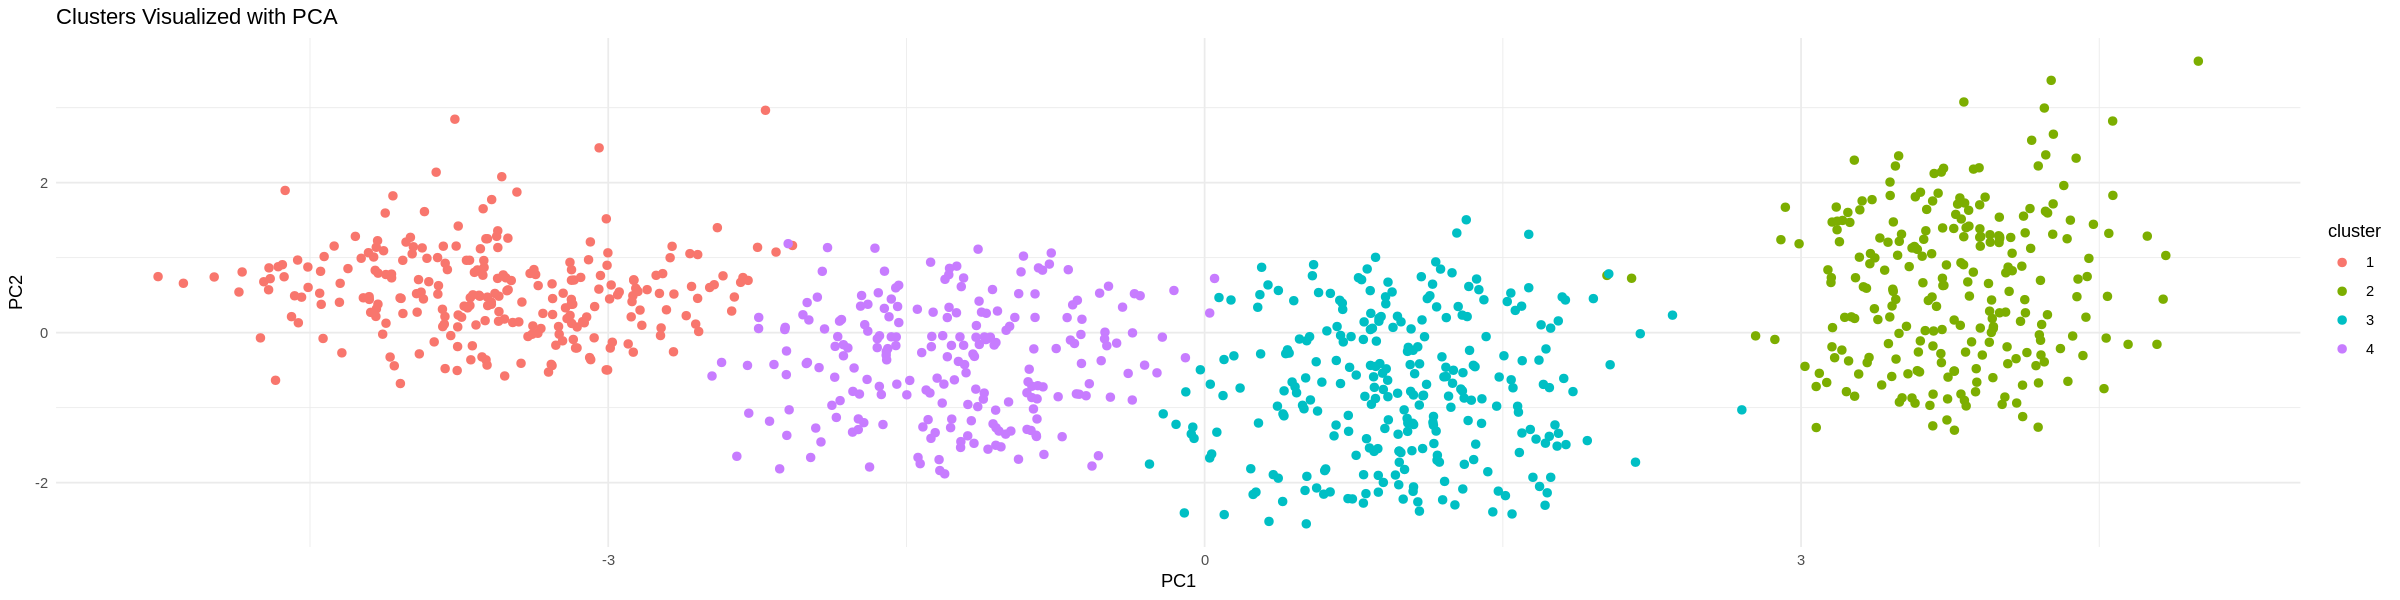

In [ ]:
pca <- prcomp(data_scaled, center = TRUE, scale. = TRUE)
pca_df <- data.frame(pca$x[, 1:2], cluster = my_data$cluster)

ggplot(pca_df, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point(size = 2) +
  theme_minimal() +
  labs(title = "Clusters Visualized with PCA", x = "PC1", y = "PC2")


# Step 7: Profiling the Clusters
- Describe the important characteristics in each of the clusters for advertisers

In [ ]:
# Keep only numeric columns
numeric_columns <- sapply(my_data, is.numeric)
summary_input <- my_data[, numeric_columns]
summary_input$cluster <- my_data$cluster

# Group by cluster and get means
library(dplyr)
cluster_summary <- summary_input %>%
  group_by(cluster) %>%
  summarise_all(mean, na.rm = TRUE)

print(cluster_summary)

# A tibble: 4 × 14
  cluster   age friends days_active hours_active likes posts groups_joined
  <fct>   <dbl>   <dbl>       <dbl>        <dbl> <dbl> <dbl>         <dbl>
1 1        25.0   447.        24.8         59.7  1198. 29.9          11.6 
2 2        59.8    79.0        8.07         7.00  156.  4.71          4.99
3 3        39.5   204.        15.0         19.4   500. 12.6           7.72
4 4        29.7   308.        19.6         40.6   809. 20.2          10.1 
# ℹ 6 more variables: pages_liked <dbl>, last_active_hours_ago <dbl>,
#   events_responded <dbl>, account_age_years <dbl>, photos_uploaded <dbl>,
#   comments_30days <dbl>


# Step 8: Overview of each different Cluster

### Visualizing Distributions of all numerical features for all clusters

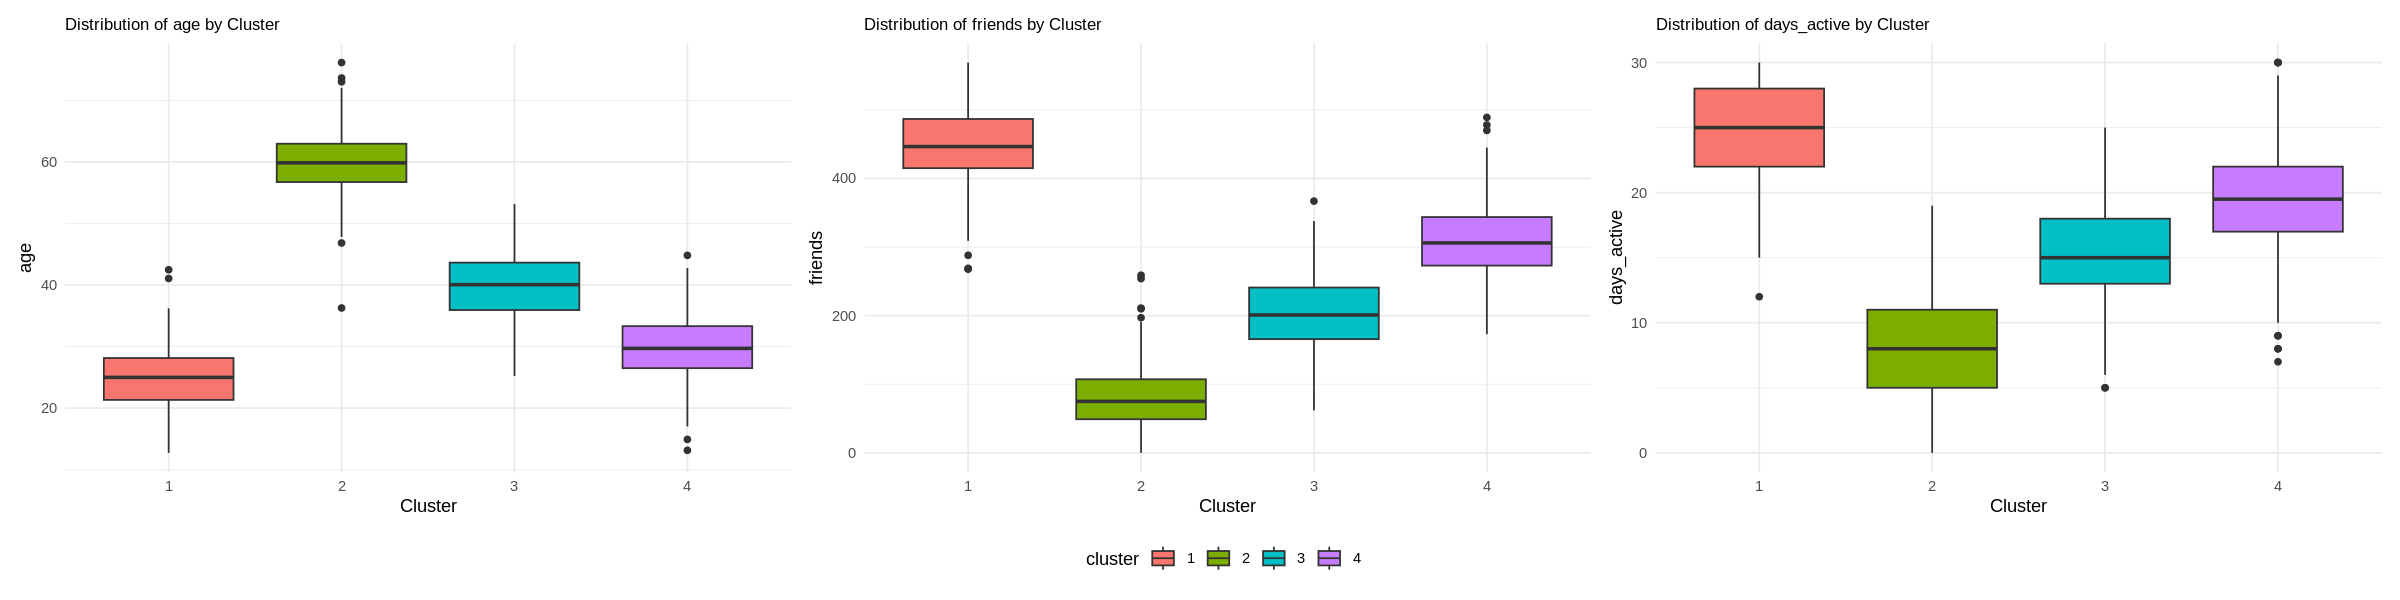

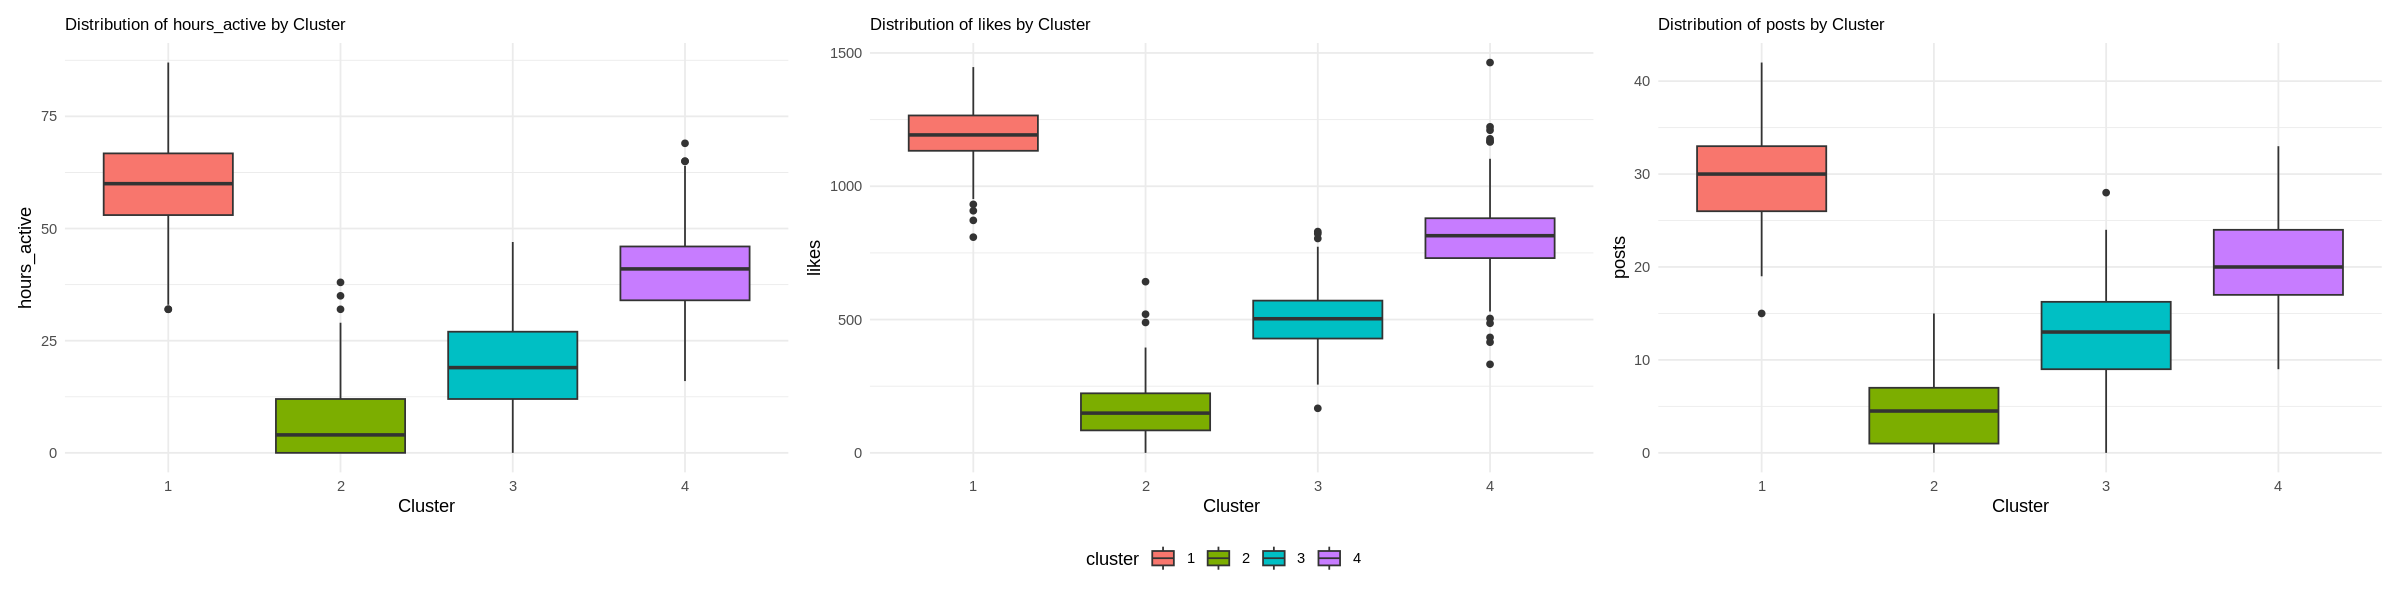

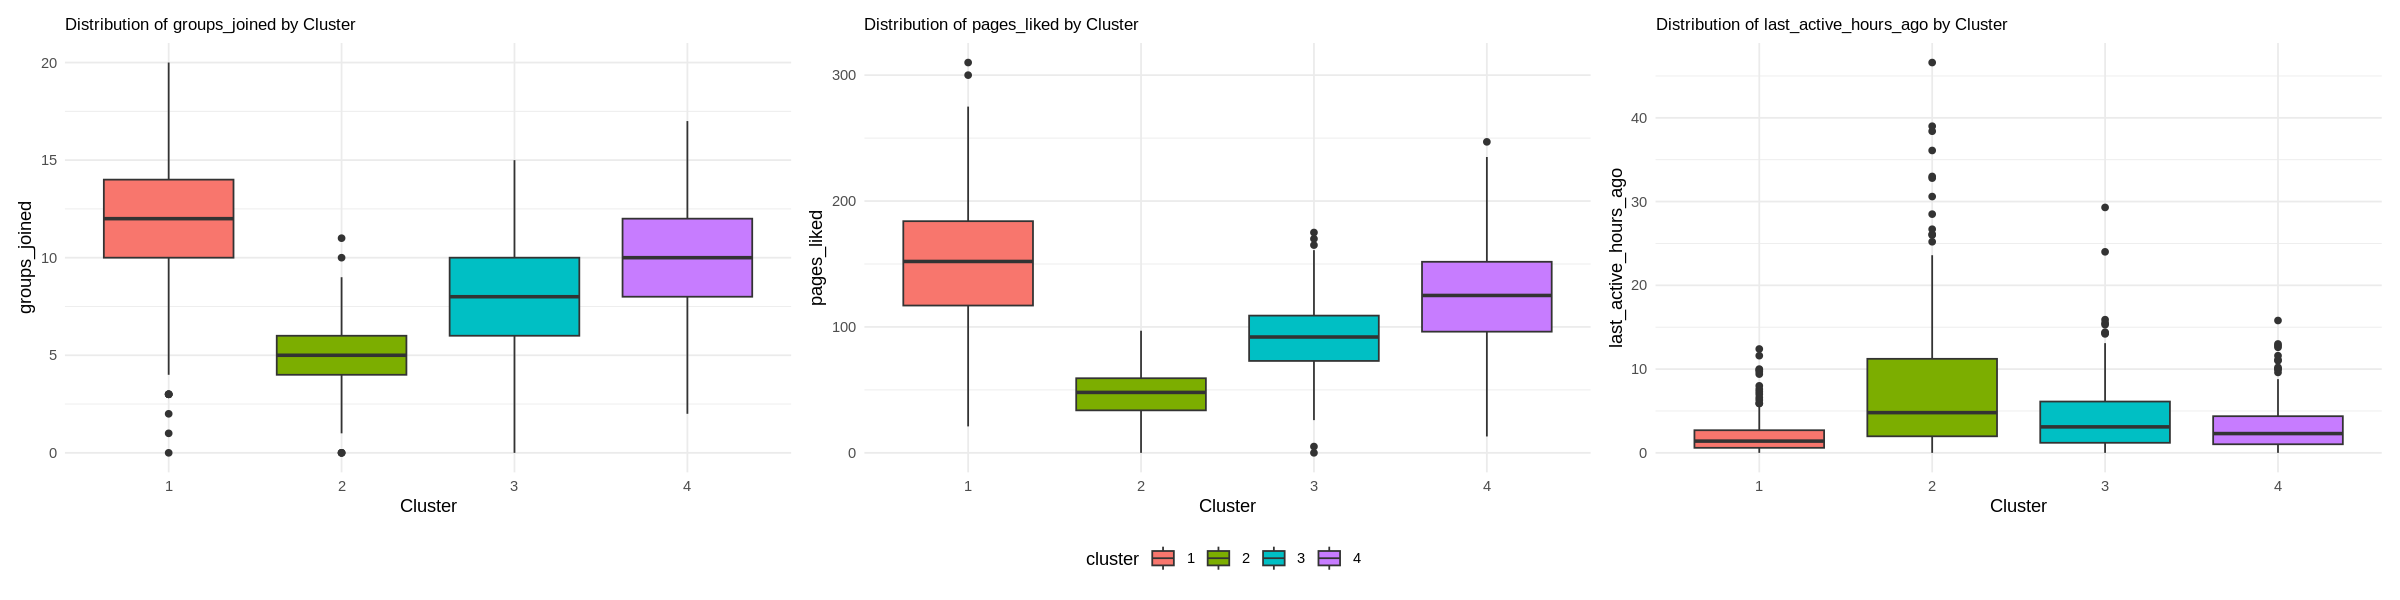

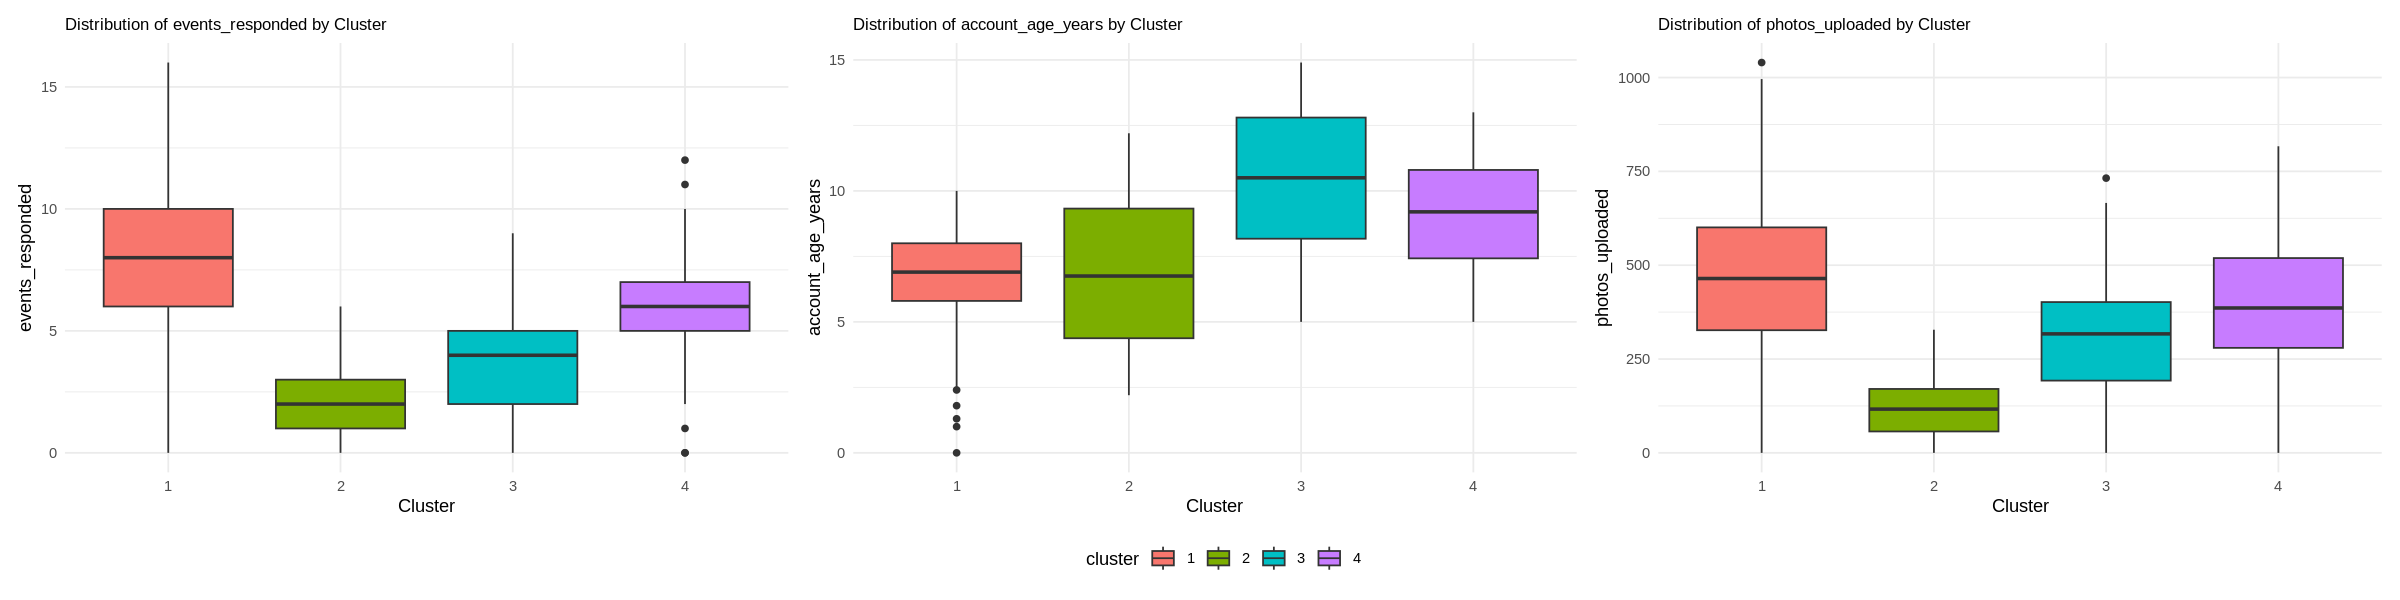

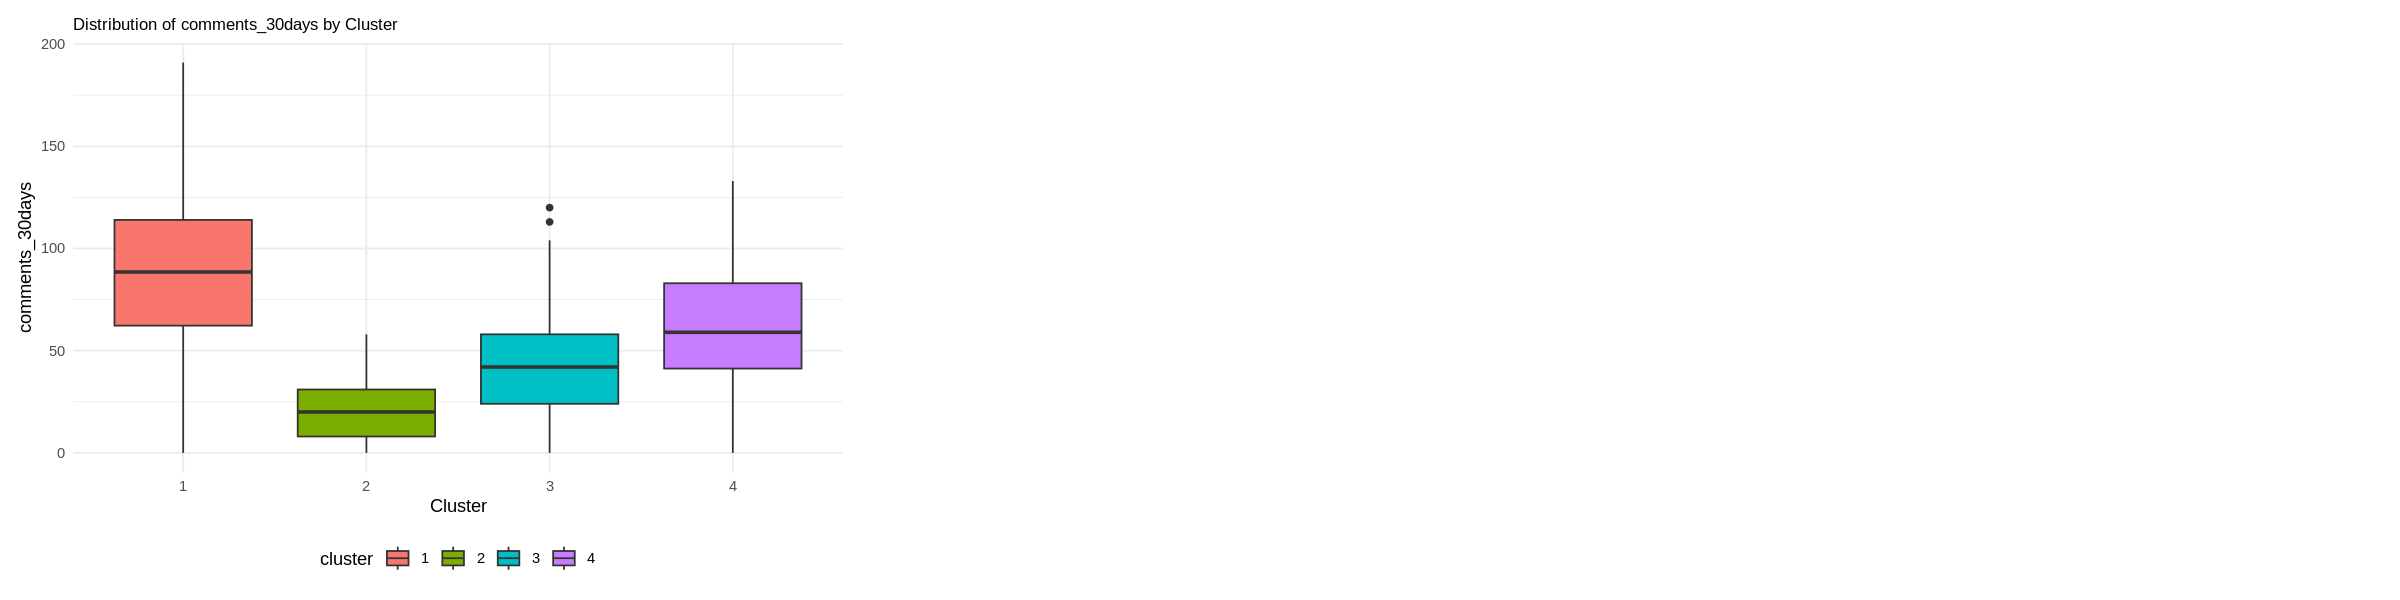

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 5)

# Convert cluster to factor
my_data$cluster <- as.factor(my_data$cluster)

# Get numeric columns
num_cols <- sapply(my_data, is.numeric)
numeric_cols <- names(my_data)[num_cols]
# Build and plot
plots <- list()
for (col in numeric_cols) {
  p <- ggplot(my_data, aes(x = cluster, y = !!sym(col), fill = cluster)) +
    geom_boxplot() +
    labs(title = paste("Distribution of", col, "by Cluster"),
         x = "Cluster", y = col) +
    theme_minimal() +
    theme(plot.title = element_text(size = 10))
  plots[[col]] <- p
}

# Show 3 per row
for (i in seq(1, length(plots), by = 3)) {
  group <- plots[i:min(i + 2, length(plots))]
  print(wrap_plots(group, ncol = 3, guides = "collect") & theme(legend.position = "bottom"))
}


### Visualizing Distributions of all categorical features for all clusters

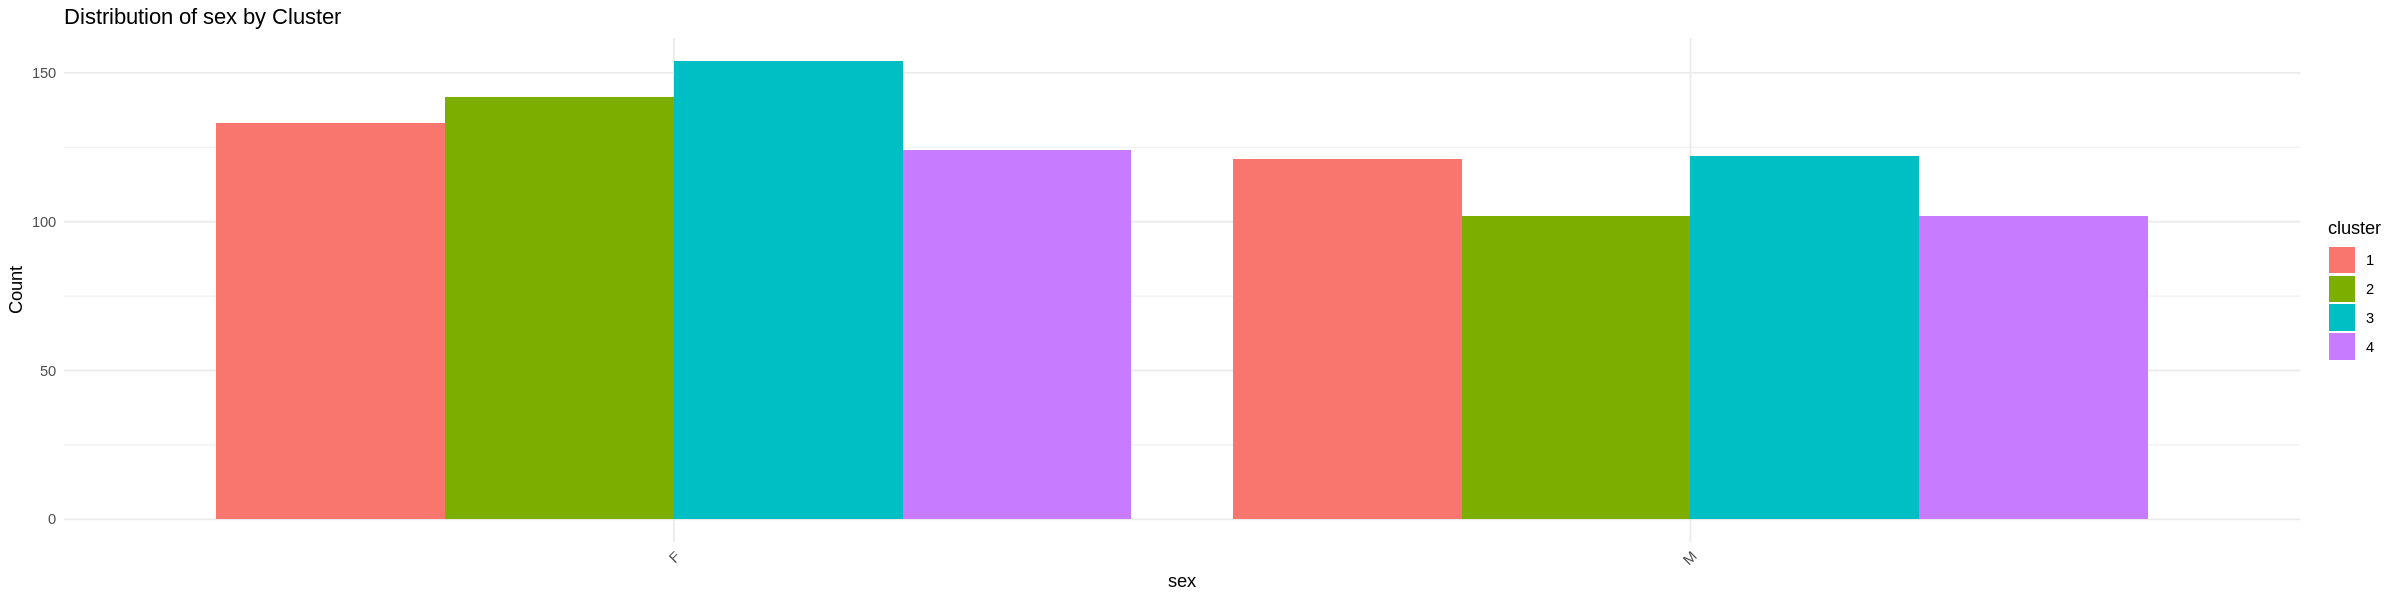

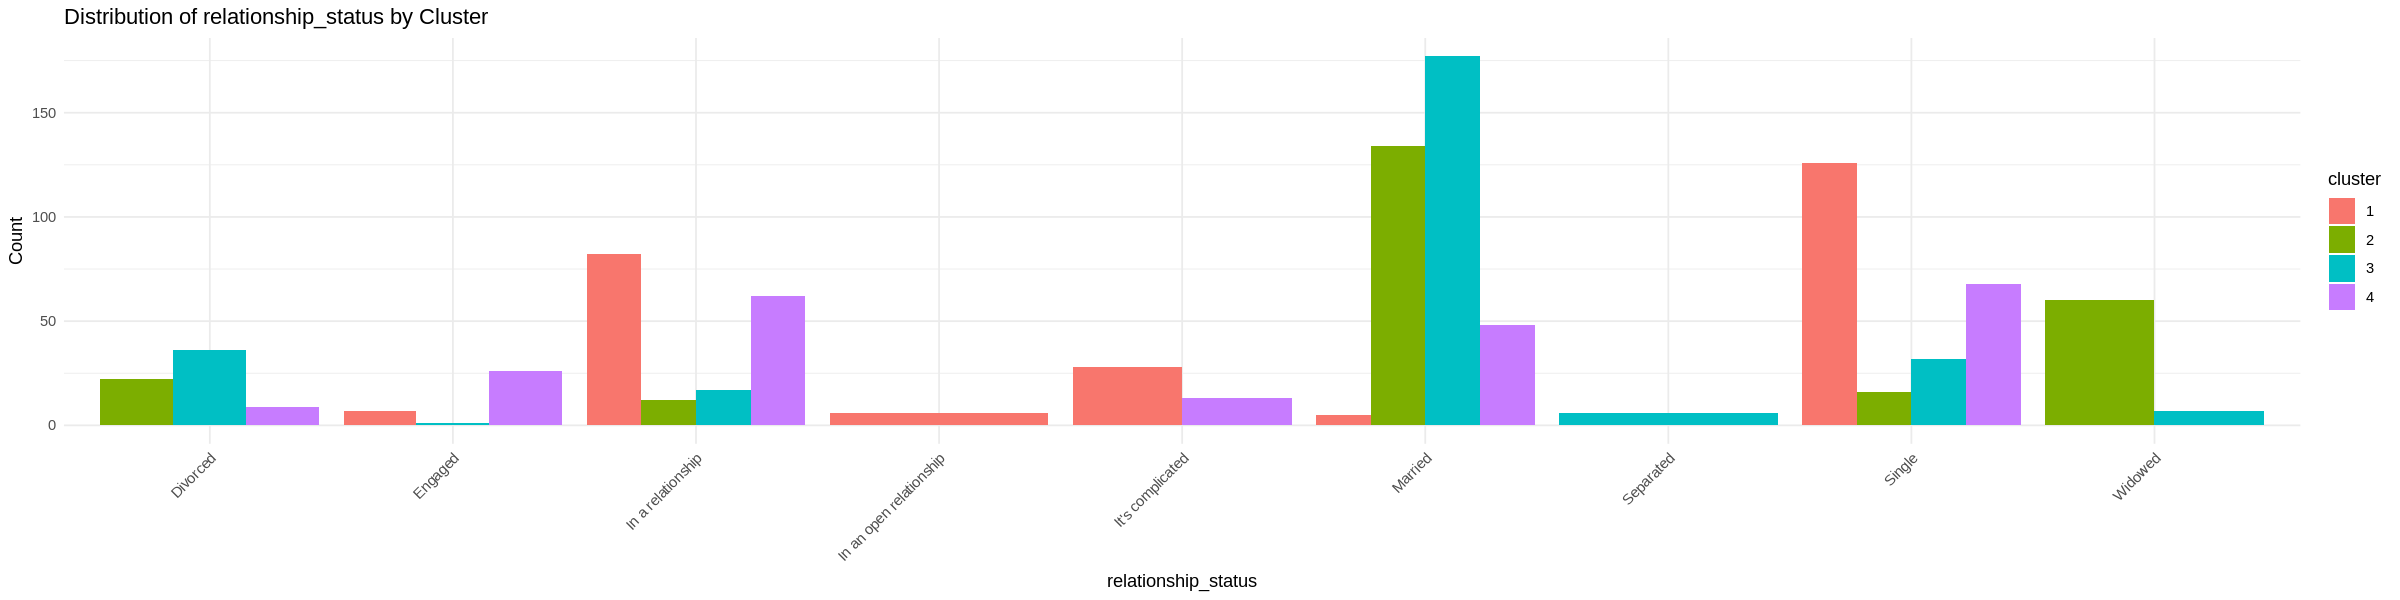

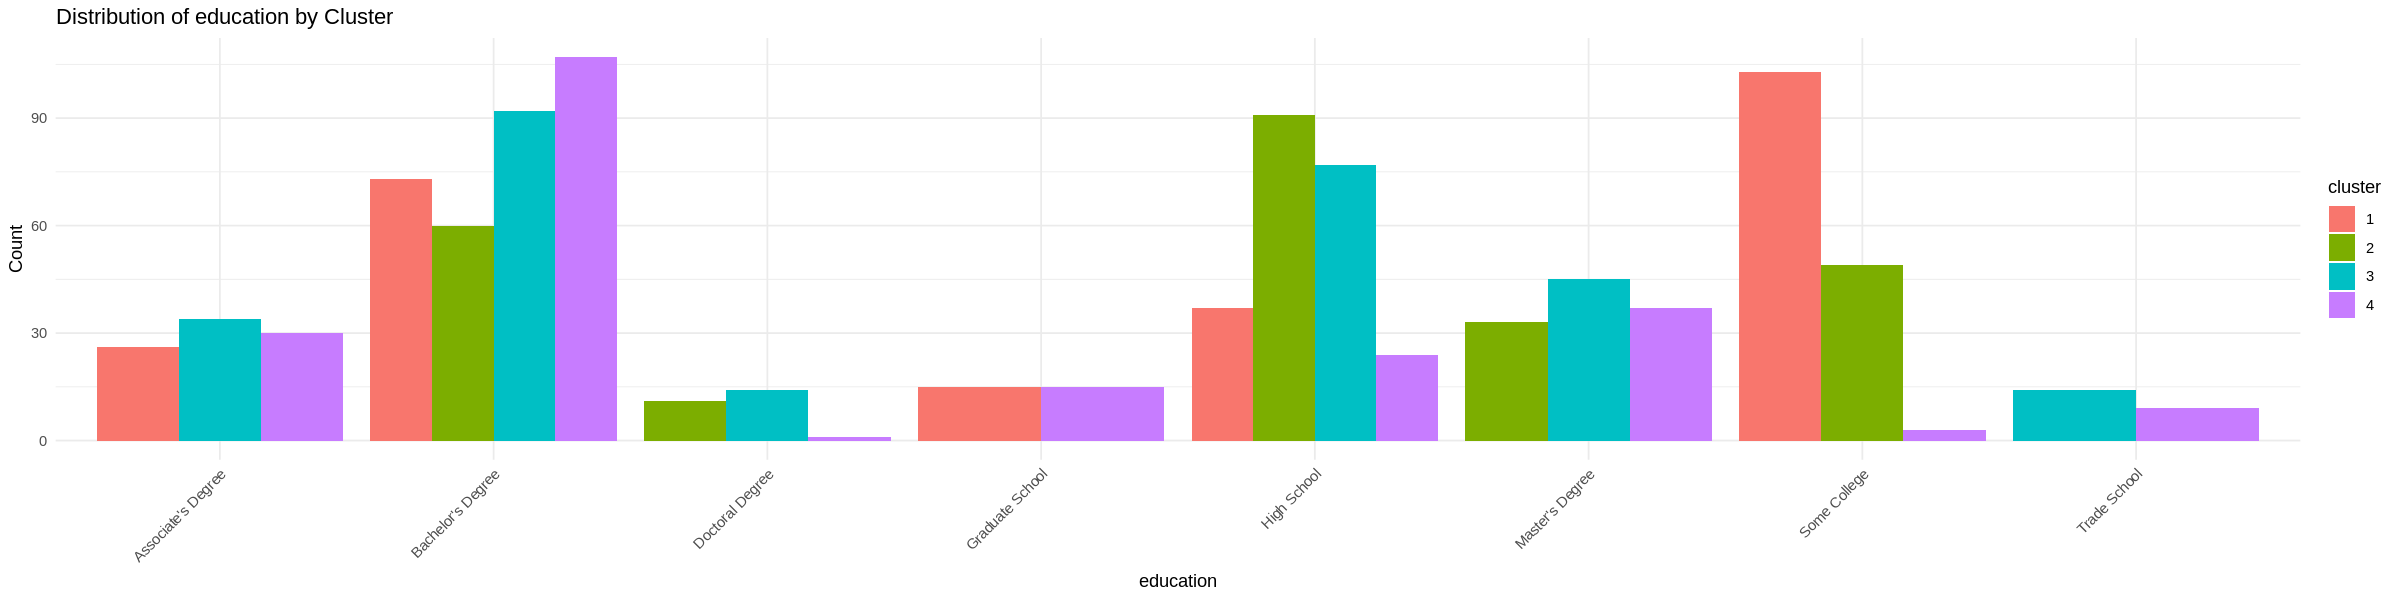

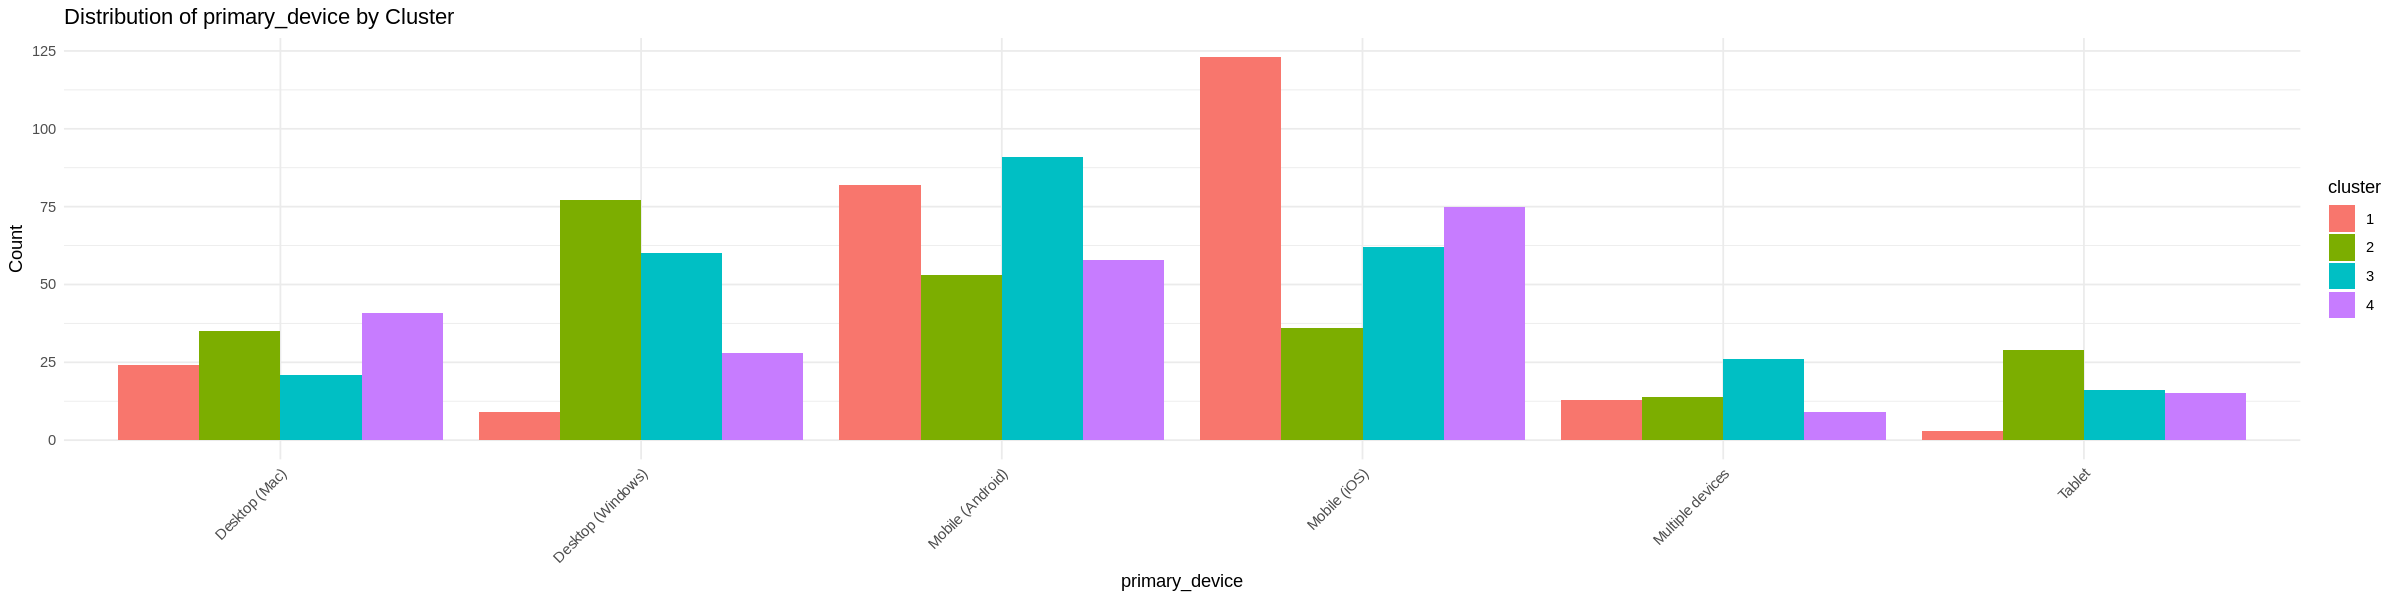

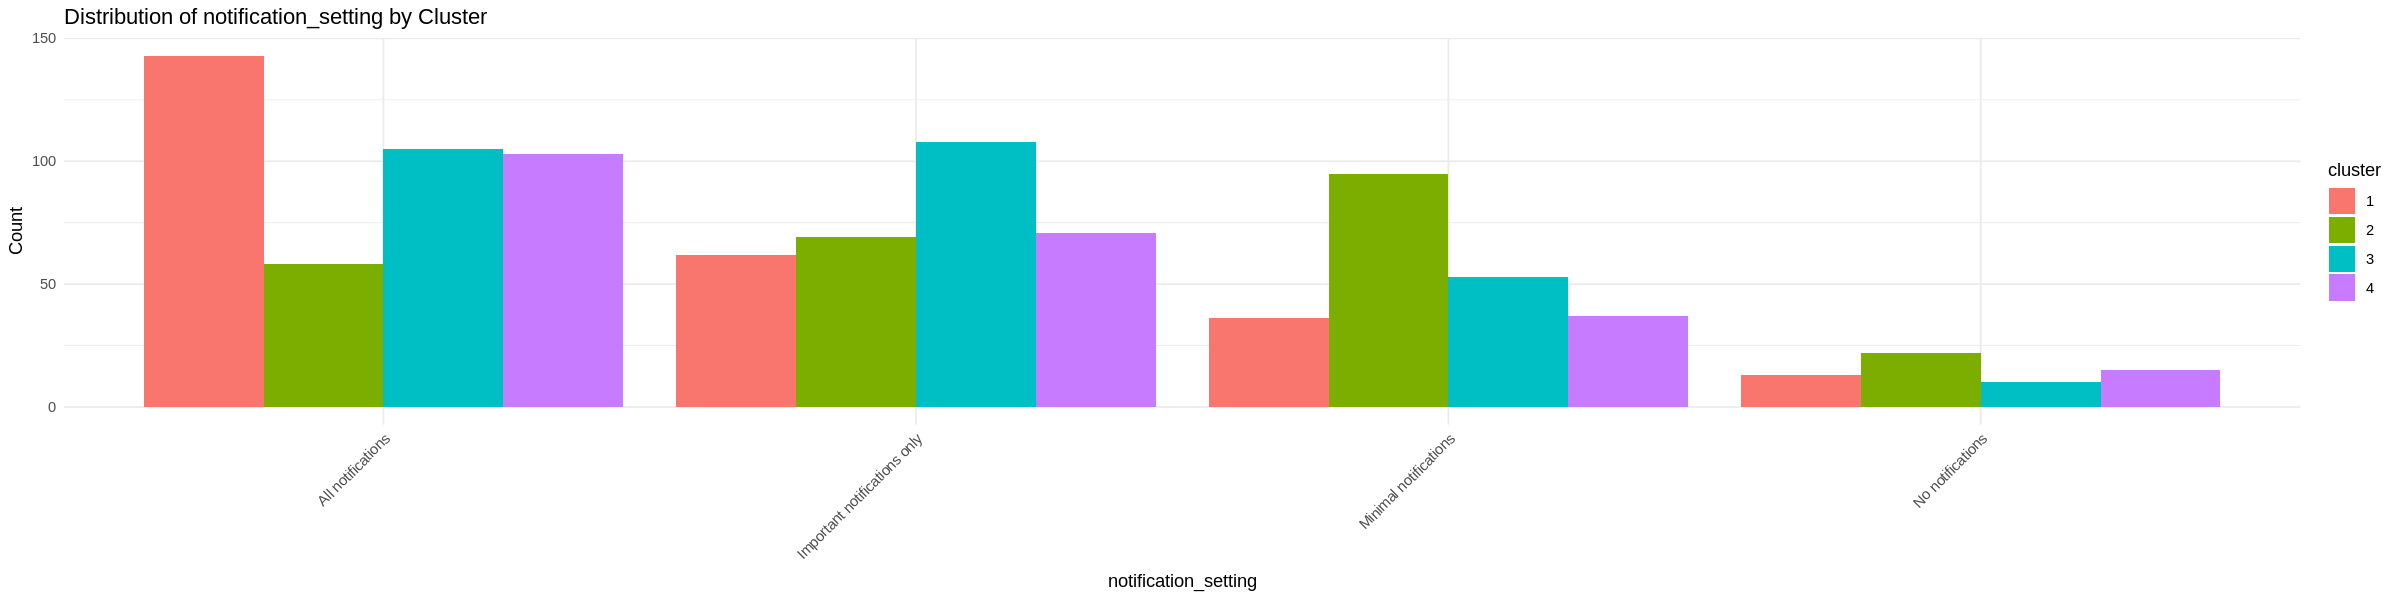

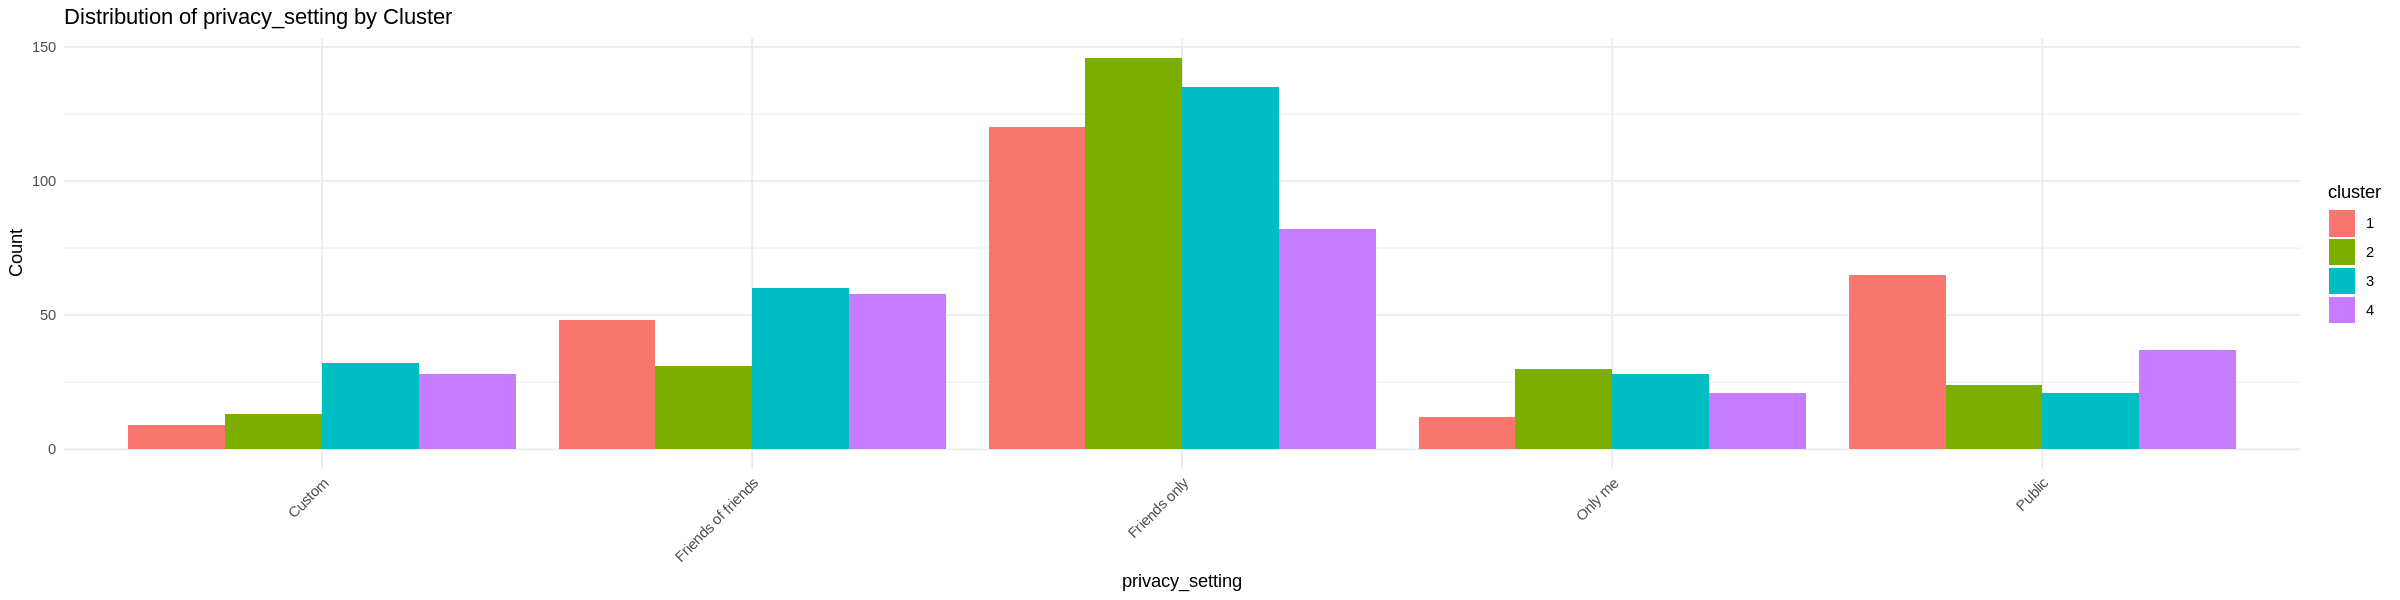

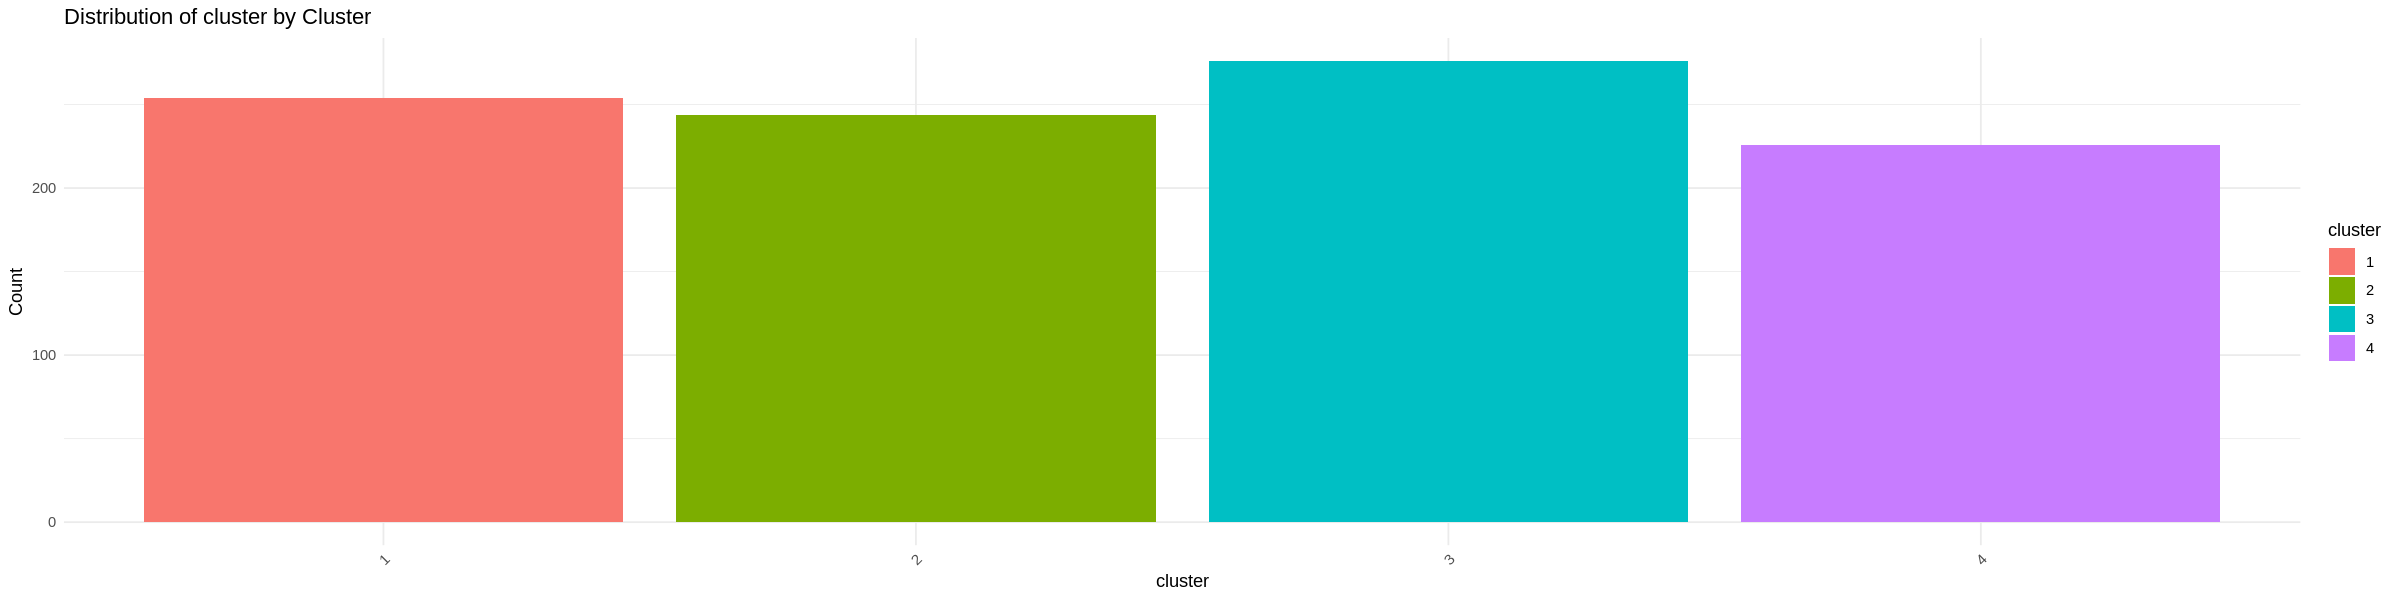

In [ ]:
library(ggplot2)
library(rlang)

# Ensure cluster is a factor
my_data$cluster <- as.factor(my_data$cluster)

# Identify all categorical columns
cat_cols <- names(my_data)[sapply(my_data, function(x) is.character(x) || is.factor(x))]

# Remove unwanted categorical columns
excluded_cols <- c("post_text", "state", "date_of_birth", "city", "cluster_name","name")
cat_cols <- setdiff(cat_cols, excluded_cols)

# Loop through and plot each cleaned categorical feature
for (col in cat_cols) {
  print(
    ggplot(my_data, aes(x = !!sym(col), fill = cluster)) +
      geom_bar(position = "dodge") +
      labs(title = paste("Distribution of", col, "by Cluster"), x = col, y = "Count") +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
  )
}


# Cluster 1 Characteristics

In [ ]:
library(dplyr)
library(tibble)
library(tidyr)

# Filter for cluster 1
cluster1_data <- my_data %>% filter(cluster == 1)

# Create labeled gender distribution
gender_dist <- prop.table(table(cluster1_data$sex)) * 100
gender_dist_labeled <- paste0(names(gender_dist), ": ", round(gender_dist, 1), "%", collapse = ", ")

# Compute and format summary
summary_stats <- cluster1_data %>%
  summarise(
    `Total Users` = n(),
    `Average Age` = mean(age, na.rm = TRUE),
    `Gender Distribution` = gender_dist_labeled,
    `Average Number of Friends` = mean(friends, na.rm = TRUE),
    `Average Likes` = mean(likes, na.rm = TRUE),
    `Average Posts` = mean(posts, na.rm = TRUE),
    `Average Comments (30 days)` = mean(comments_30days, na.rm = TRUE),
    `Average Days Active` = mean(days_active, na.rm = TRUE),
    `Average Hours Active` = mean(hours_active, na.rm = TRUE),
    `Average Groups Joined` = mean(groups_joined, na.rm = TRUE),
    `Average Pages Liked` = mean(pages_liked, na.rm = TRUE),
    `Most Common Device` = names(sort(table(cluster1_data$primary_device), decreasing = TRUE))[1],
    `Average Account Age (years)` = mean(account_age_years, na.rm = TRUE),
    `Average Events Responded To` = mean(events_responded, na.rm = TRUE)
  ) %>%
  mutate(across(everything(), as.character)) %>%
  pivot_longer(cols = everything(), names_to = "Statistic", values_to = "Value")

# Print tidy summary
print(summary_stats)


# A tibble: 14 × 2
   Statistic                   Value             
   <chr>                       <chr>             
 1 Total Users                 254               
 2 Average Age                 25.0339144843919  
 3 Gender Distribution         F: 52.4%, M: 47.6%
 4 Average Number of Friends   447.090551181102  
 5 Average Likes               1198.44488188976  
 6 Average Posts               29.9015748031496  
 7 Average Comments (30 days)  88.6614173228347  
 8 Average Days Active         24.759842519685   
 9 Average Hours Active        59.6889763779528  
10 Average Groups Joined       11.6220472440945  
11 Average Pages Liked         152.464566929134  
12 Most Common Device          Mobile (iOS)      
13 Average Account Age (years) 6.86653543307087  
14 Average Events Responded To 8.04724409448819  


# Cluster 2 Characteristics

In [ ]:
library(dplyr)
library(tibble)
library(tidyr)

# Filter for cluster 2
cluster1_data <- my_data %>% filter(cluster == 2)

# Create labeled gender distribution
gender_dist <- prop.table(table(cluster1_data$sex)) * 100
gender_dist_labeled <- paste0(names(gender_dist), ": ", round(gender_dist, 1), "%", collapse = ", ")

# Compute and format summary
summary_stats <- cluster1_data %>%
  summarise(
    `Total Users` = n(),
    `Average Age` = mean(age, na.rm = TRUE),
    `Gender Distribution` = gender_dist_labeled,
    `Average Number of Friends` = mean(friends, na.rm = TRUE),
    `Average Likes` = mean(likes, na.rm = TRUE),
    `Average Posts` = mean(posts, na.rm = TRUE),
    `Average Comments (30 days)` = mean(comments_30days, na.rm = TRUE),
    `Average Days Active` = mean(days_active, na.rm = TRUE),
    `Average Hours Active` = mean(hours_active, na.rm = TRUE),
    `Average Groups Joined` = mean(groups_joined, na.rm = TRUE),
    `Average Pages Liked` = mean(pages_liked, na.rm = TRUE),
    `Most Common Device` = names(sort(table(cluster1_data$primary_device), decreasing = TRUE))[1],
    `Average Account Age (years)` = mean(account_age_years, na.rm = TRUE),
    `Average Events Responded To` = mean(events_responded, na.rm = TRUE)
  ) %>%
  mutate(across(everything(), as.character)) %>%
  pivot_longer(cols = everything(), names_to = "Statistic", values_to = "Value")

# Print tidy summary
print(summary_stats)


# A tibble: 14 × 2
   Statistic                   Value             
   <chr>                       <chr>             
 1 Total Users                 244               
 2 Average Age                 59.8137090686202  
 3 Gender Distribution         F: 58.2%, M: 41.8%
 4 Average Number of Friends   79.0409836065574  
 5 Average Likes               156.372950819672  
 6 Average Posts               4.71311475409836  
 7 Average Comments (30 days)  19.9385245901639  
 8 Average Days Active         8.0655737704918   
 9 Average Hours Active        7.00409836065574  
10 Average Groups Joined       4.98770491803279  
11 Average Pages Liked         46.9713114754098  
12 Most Common Device          Desktop (Windows) 
13 Average Account Age (years) 6.91393442622951  
14 Average Events Responded To 2.00819672131148  


# Cluster 3 Characteristics

In [ ]:
library(dplyr)
library(tibble)
library(tidyr)

# Filter for cluster 3
cluster1_data <- my_data %>% filter(cluster == 3)

# Create labeled gender distribution
gender_dist <- prop.table(table(cluster1_data$sex)) * 100
gender_dist_labeled <- paste0(names(gender_dist), ": ", round(gender_dist, 1), "%", collapse = ", ")

# Compute and format summary
summary_stats <- cluster1_data %>%
  summarise(
    `Total Users` = n(),
    `Average Age` = mean(age, na.rm = TRUE),
    `Gender Distribution` = gender_dist_labeled,
    `Average Number of Friends` = mean(friends, na.rm = TRUE),
    `Average Likes` = mean(likes, na.rm = TRUE),
    `Average Posts` = mean(posts, na.rm = TRUE),
    `Average Comments (30 days)` = mean(comments_30days, na.rm = TRUE),
    `Average Days Active` = mean(days_active, na.rm = TRUE),
    `Average Hours Active` = mean(hours_active, na.rm = TRUE),
    `Average Groups Joined` = mean(groups_joined, na.rm = TRUE),
    `Average Pages Liked` = mean(pages_liked, na.rm = TRUE),
    `Most Common Device` = names(sort(table(cluster1_data$primary_device), decreasing = TRUE))[1],
    `Average Account Age (years)` = mean(account_age_years, na.rm = TRUE),
    `Average Events Responded To` = mean(events_responded, na.rm = TRUE)
  ) %>%
  mutate(across(everything(), as.character)) %>%
  pivot_longer(cols = everything(), names_to = "Statistic", values_to = "Value")

# Print tidy summary
print(summary_stats)


# A tibble: 14 × 2
   Statistic                   Value             
   <chr>                       <chr>             
 1 Total Users                 276               
 2 Average Age                 39.5449171550577  
 3 Gender Distribution         F: 55.8%, M: 44.2%
 4 Average Number of Friends   204.471014492754  
 5 Average Likes               500.213768115942  
 6 Average Posts               12.6159420289855  
 7 Average Comments (30 days)  42.0217391304348  
 8 Average Days Active         14.9782608695652  
 9 Average Hours Active        19.4166666666667  
10 Average Groups Joined       7.72101449275362  
11 Average Pages Liked         91.3913043478261  
12 Most Common Device          Mobile (Android)  
13 Average Account Age (years) 10.3239130434783  
14 Average Events Responded To 3.88768115942029  


# Cluster 4 Characteristics

In [ ]:
library(dplyr)
library(tibble)
library(tidyr)

# Filter for cluster 4
cluster1_data <- my_data %>% filter(cluster == 4)

# Create labeled gender distribution
gender_dist <- prop.table(table(cluster1_data$sex)) * 100
gender_dist_labeled <- paste0(names(gender_dist), ": ", round(gender_dist, 1), "%", collapse = ", ")

# Compute and format summary
summary_stats <- cluster1_data %>%
  summarise(
    `Total Users` = n(),
    `Average Age` = mean(age, na.rm = TRUE),
    `Gender Distribution` = gender_dist_labeled,
    `Average Number of Friends` = mean(friends, na.rm = TRUE),
    `Average Likes` = mean(likes, na.rm = TRUE),
    `Average Posts` = mean(posts, na.rm = TRUE),
    `Average Comments (30 days)` = mean(comments_30days, na.rm = TRUE),
    `Average Days Active` = mean(days_active, na.rm = TRUE),
    `Average Hours Active` = mean(hours_active, na.rm = TRUE),
    `Average Groups Joined` = mean(groups_joined, na.rm = TRUE),
    `Average Pages Liked` = mean(pages_liked, na.rm = TRUE),
    `Most Common Device` = names(sort(table(cluster1_data$primary_device), decreasing = TRUE))[1],
    `Average Account Age (years)` = mean(account_age_years, na.rm = TRUE),
    `Average Events Responded To` = mean(events_responded, na.rm = TRUE)
  ) %>%
  mutate(across(everything(), as.character)) %>%
  pivot_longer(cols = everything(), names_to = "Statistic", values_to = "Value")

# Print tidy summary
print(summary_stats)


# A tibble: 14 × 2
   Statistic                   Value             
   <chr>                       <chr>             
 1 Total Users                 226               
 2 Average Age                 29.7334983516208  
 3 Gender Distribution         F: 54.9%, M: 45.1%
 4 Average Number of Friends   308.371681415929  
 5 Average Likes               809.159292035398  
 6 Average Posts               20.1548672566372  
 7 Average Comments (30 days)  59.9823008849558  
 8 Average Days Active         19.6061946902655  
 9 Average Hours Active        40.6106194690265  
10 Average Groups Joined       10.0884955752212  
11 Average Pages Liked         126.438053097345  
12 Most Common Device          Mobile (iOS)      
13 Average Account Age (years) 9.18761061946903  
14 Average Events Responded To 5.94247787610619  
